<a href="https://colab.research.google.com/github/nealcaren/BIGSSS-LLM/blob/main/LLM_1_DIY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Large Langue Models to Extract Information from Text


This set of notebooks introduces some techniques for use large langauage models (LLMs) for turning text into data.


Before you begin, from the menus above, select Runtime->Change runtime type and select "GPU" under "Hardware accelerator." This will speed up inference.

These lines install the required packages. The `!pip install` command is used to install Python packages from the Python Package Index (PyPI). Here, we are installing `transformers` and  `accelerate`.

In [1]:
!pip install transformers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 11.0 MB/s eta 0:00:00


These lines import the necessary libraries. `torch` is the main library for deep learning in Python (but we are just using it check to see if a GPU is available) and  `pipeline` are classes from the `transformers` library that we will use to generate text.


In [2]:
import torch
from transformers import pipeline

 In the next code block, we first check if a CUDA-enabled GPU is available using the torch.cuda.is_available() function. If a GPU is available, we set the device to "cuda:0", indicating that the model should be run on the GPU. Otherwise, if no GPU is available, the device is set to "cpu", indicating that the model should be run on the CPU. This step is crucial for optimizing performance, as running large language models on a GPU can significantly speed up computations. After setting the device, we initialize the text_generator pipeline using the "text2text-generation" task and the "google/flan-t5-base" model. We also specify the device to be used by the pipeline, ensuring it matches the device we previously set. Additionally, we set the maximum length of the generated text to be 200 tokens.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

text_generator = pipeline("text2text-generation",
                          model="google/flan-t5-base",
                          device = device,
                           max_length=200)

The next line of code calls the text_generator pipeline to generate a response based on the provided input text. Here, we are asking it to generate an article title based on an abstract.

In [4]:
text_generator('''What is a good article title based on this abstract?
One starting point for building a movement capable of unleashing multiple rounds of collective action is an incubator campaign—a period of widespread unrest around a particular issue that may last several months or longer. The mobilizing success of the incubator campaign provides the resource infrastructure for subsequent episodes of related movement activity in similar geographical locations, even years into the future. We test these assertions by examining immigrant rights campaign activity in over 260 cities in California between 2006 and 2019. The incubator campaign was positively associated with producing local-level collective action in a wide range of like-minded campaigns sustaining a larger immigrant rights movement in the state. The findings also suggest that an incubator campaign’s influence may eventually decay over time. Still, newly infused protest campaigns can reactivate immigrant activist momentum to counter ongoing hostile political environments faced by excluded populations.
''')

[{'generated_text': 'Immigrant rights campaign activity in California: a case study'}]

**Your Turn**

Replace PUT YOUR TEXT HERE with whatever you want. Play around. What are some strengths and weakness of the model?

In [5]:
text_generator('''PUT YOUR TEXT HERE''')


[{'generated_text': '                                                                                                   '}]

Now, time to put it to use. We want to use the model to classify texts. Start with a sample review:

In [6]:
review = '''Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.'''


 The next code  block sets a prompt string that introduces the task to our new *text classification assistant*. It includes a placeholder {review} where the movie review text will be inserted. The prompt instructs the assistant to choose the label with the highest probability from the following possibilities: "positive" or "negative". The expected response is only the label itself, without any additional information.

Finally, the text_generator function is called with the prompt string as an argument. The pipeline will utilize the pre-trained model to generate a response, which should be the predicted label (either "positive" or "negative") based on the movie review provided.

In [7]:
prompt = f"""You are a text classification assistant.

The text to classify:

```
{review}
```

Choose the label among the following possibilities with the highest probability.
Only return the label, nothing more:

["positive", "negative]

Your response:
"""

text_generator(prompt)

[{'generated_text': 'negative'}]

The response is a list containing a single dictionary element. Below, the generated text is accessed using `response[0]['generated_text']`, which extracts the generated text from the dictionary.

In this case, the generated text is "negative", indicating that the predicted sentiment for the movie review is negative. The variable sentiment is then assigned this predicted sentiment value for further use in the code.

In [8]:
response = text_generator(prompt)
sentiment = response[0]['generated_text']

Let's ask a different question.

In [9]:
prompt = f"""
```
{review}
```

What genre of movie is this?

Your response:
"""

text_generator(prompt)



[{'generated_text': 'Drama'}]

**Your Turn**

Replace PUT YOUR TEXT HERE with whatever you want. Play around! Feel free to ask the question different ways, or format the questions differently, such as not putting "Your response:" or putting the review at the end.



In [10]:
prompt = f"""
```
{review}
```

PUT YOUR TEXT HERE

Your response:
"""

text_generator(prompt)



[{'generated_text': "I'm not sure what the movie is about, but I'm not sure what it's about."}]

Now, let's evaluate how this works against a human-coded dataset of IMDB reviews.

In [11]:
import pandas as pd

df = pd.read_csv('https://www.dropbox.com/s/72n7a8u47mxntp9/IMDB%20Dataset.csv?raw=1')

Let's just use 10 cases.

In [12]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

dfs10 = df.sample(10)
dfs10

,review,sentiment
7538,When I was kid back in the 1970s a local theat...,negative
40802,If you would like to watch an example of how n...,negative
900,"A wonderful film ahead of its time,<br /><br /...",positive
48489,... This isn't the first time Stanley blurred ...,positive
22763,I couldn't believe how lame & pointless this w...,negative
33854,Well another shootem up. Typical run around fi...,negative
45370,I Am Curious is really two films in one - half...,negative
10435,I thought Sliver offered the most boring and t...,negative
38420,"I went into this film expecting a slasher, and...",positive
49074,Anyone remember the docudrama THREADS ? It's a...,negative


The next cell creates a function that takes a text string, `review` appends our sentiment question, and returns whatever the models replies with.

In [13]:
def analyze_sentiment(review):
    """
    Analyzes the sentiment of a given review text.

    Args:
        review (str): The review text to be analyzed.

    Returns:
        str: The predicted sentiment label ("positive" or "negative").
    """

    # Define the prompt string for the text classification assistant
    prompt = f"""You are a text classification assistant.

    The text to classify:

    ```
    {review}
    ```

    Choose the label among the following possibilities with the highest probability.
    Only return the label, nothing more:

    ["positive", "negative"]

    Your response:
    """

    # Uncomment this line to see each prompt
    # print(prompt)

    # Generate the response using the text generator pipeline
    response = text_generator(prompt)

    # Extract the generated sentiment label from the response
    sentiment = response[0]['generated_text']

    # Return the predicted sentiment label
    return sentiment


We can `apply()` the new function to a column in the dataframe and store the resutls in a new column, `sentiment_pred`.

In [14]:
dfs10['sentiment_pred'] = dfs10['review'].apply(analyze_sentiment)

Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [15]:
dfs10

,review,sentiment,sentiment_pred
7538,When I was kid back in the 1970s a local theat...,negative,negative
40802,If you would like to watch an example of how n...,negative,negative
900,"A wonderful film ahead of its time,<br /><br /...",positive,positive
48489,... This isn't the first time Stanley blurred ...,positive,positive
22763,I couldn't believe how lame & pointless this w...,negative,negative
33854,Well another shootem up. Typical run around fi...,negative,negative
45370,I Am Curious is really two films in one - half...,negative,negative
10435,I thought Sliver offered the most boring and t...,negative,negative
38420,"I went into this film expecting a slasher, and...",positive,positive
49074,Anyone remember the docudrama THREADS ? It's a...,negative,negative


How did we do?

In [16]:
pd.crosstab(dfs10['sentiment'], dfs10['sentiment_pred'])

sentiment_pred,negative,positive
sentiment,,
negative,7,0
positive,0,3


Let's try it on a larger sample.

In [17]:
dfs200 = df.groupby('sentiment').sample(100)
dfs200['sentiment_pred'] = dfs200['review'].apply(analyze_sentiment)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [18]:
pd.crosstab(dfs200['sentiment'], dfs200['sentiment_pred'])

sentiment_pred,negative,positive
sentiment,,
negative,95,5
positive,14,86


We can use some of the fit metrics from `sklearn` to evaluate how well we did.

Accuracy:  0.905


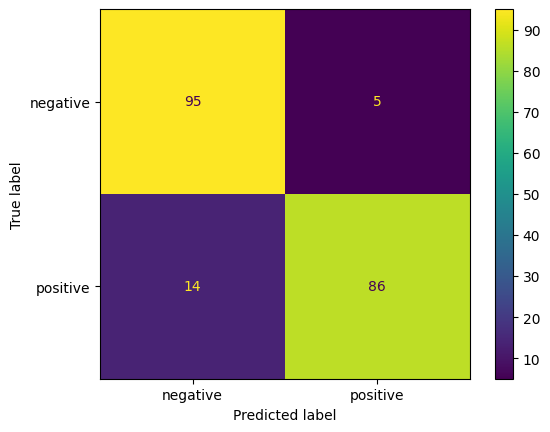

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(dfs200['sentiment'], dfs200['sentiment_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=['negative','positive'])
disp.plot()
print('Accuracy: ',accuracy_score(dfs200['sentiment'], dfs200['sentiment_pred']))


You should also look at the wrong cases to see if you can uncover the sources of the error.

In [21]:
dfs200[dfs200['sentiment'] != dfs200['sentiment_pred']]

,review,sentiment,sentiment_pred
36333,"I know no one cares, but I do. This film is hi...",negative,positive
14772,"""The Man From Utah"" opens with a singing cowbo...",negative,positive
36662,Saw this movie at a Saturday matinée with a fr...,negative,positive
39629,I enjoyed the beautiful scenery in this movie ...,negative,positive
25785,"In one sense, I kind of liked this movie becau...",negative,positive
11093,"Between the ages of 30 and 51, when he died of...",positive,negative
29336,A story of love between two people at the end ...,positive,negative
4758,"To paraphrase Thora Birch: ""I kind of like thi...",positive,negative
17788,I watched this movie alongwith my complete fam...,positive,negative
2373,I found this one to be more chaotic than the a...,positive,negative


**Your Turn:** The next few cells load a [dataset](https://huggingface.co/datasets/dair-ai/emotion) of tweets coded by emotion.

In [22]:
emotions_df_full = pd.read_csv('https://www.dropbox.com/scl/fi/5811cfclfulyz31ardgzu/emotions_16K.csv?dl=1&rlkey=jztgt5fpbcqa82mbq554gpbsg')

In [23]:
# create a balanced sample
emotions_df = emotions_df_full.groupby("emotion").sample(n=10)
# shuffle
emotions_df = emotions_df.sample(frac=1.0)
emotions_df.reset_index(inplace=True, drop=True)

print(len(emotions_df))
emotions_df

60


,text,emotion
0,i don t usually blog when i m feeling this way...,surprise
1,i am now nearly finished the week detox and i ...,surprise
2,i feel stupid and thoughtless,sadness
3,i feel that i am not accepted and am forced to...,love
4,i frantically try to get it done and now feel ...,fear
5,i would be the one screaming and yelling but n...,sadness
6,i could feel myself hit this strange foggy wall,surprise
7,im feeling annoyed to add on i dont feel impor...,anger
8,i am sharing information that i feel is import...,joy
9,i believe if you have happy and healthy relati...,joy


The possible emotions.

In [24]:
elabels = sorted(list(emotions_df['emotion'].value_counts().index))
elabels

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

Your mission is to replace YOUR PROMPT WORDS GO HERE, or otherwise modify the function below to get it work the best you can!

In [25]:
def analyze_tweet_emotion(tweet):
    """
    Analyzes the emotions of a given social media post.

    Args:
        review (str): The review text to be analyzed.

    Returns:
        str: The predicted sentiment label ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'].
    """

    # Define the prompt string for the text classification assistant
    prompt = f"""You are a text classification assistant.

    The text to classify:

    ```
    {tweet}
    ```

    Choose the label among the following possibilities with the highest probability.
    Only return the label, nothing more:

    ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

    Your response:
    """

    # Uncomment this line to see each prompt
    # print(prompt)

    # Generate the response using the text generator pipeline
    response = text_generator(prompt)

    # Extract the generated sentiment label from the response
    emotion = response[0]['generated_text']

    # Return the predicted emotion label
    return emotion


In [26]:
analyze_tweet_emotion("i feel remorseful for not making the most with them")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


'sadness'

Run your model and evaluate. You probably don't need to change anything here.

In [27]:
emotions_df['emotion_pred'] = emotions_df['text'].apply(analyze_tweet_emotion)
print('Accuracy: ',accuracy_score(emotions_df['emotion'], emotions_df['emotion_pred']))
pd.crosstab(emotions_df['emotion'], emotions_df['emotion_pred'])

Accuracy:  0.5833333333333334


emotion_pred,anger,fear,joy,love,sadness,surprise
emotion,,,,,,
anger,8,0,0,0,2,0
fear,3,3,0,0,3,1
joy,2,0,5,1,1,1
love,0,0,0,3,7,0
sadness,4,0,0,0,6,0
surprise,0,0,0,0,0,10


Summary of Part I:

* With access to a modest GPU, you can run your own small large-language model.
* It can be used to code straightforward questions.
* You need to check on it before scaling up.
* Can be useful for preliminary work, such as what are plausible categories when you haven't systematically reviewed the corpus yet.
* The process of installing dependencies can be brittle.
* Works best with short texts.
* It can confabulate/halluciante in biased ways, for all meanings of the word bias.